In [3]:
from sys import path as syspath
from pathlib import Path

syspath.append(str(Path().home() / "pyref" / "src"))

import pyref as rf
import seaborn as sns
from pyref.fitting import converters as cv

# Loading the Data

Luckily, most data has been processed allready, and can be loaded using the `csv_to_refl` function. This function facilitates the loading of csv files and returns a reflectdataset object. 

In [ ]:
db = rf.db()

refl_data = db / ".data" / "xrr"

There are three samples that we want to analyze. 
1. Bare Silicon
2. Room Temperature deposited ZnPc
3. C60 | ZnPc Bilayer

Luckily, we have a query function that can be used to find the correct files. As of right now, the query function is not very robust, and tatabase structure is generated by hand. 

In [ ]:
pss_thick = 1500
pss_rough = 3


def get_n(df, en_index):
    n_df = df[r"$\delta$"] + 1j * df[r"$\beta$"]
    if en_index in df.index:
        return n_df[en_index]

    for i, en in enumerate(df.index):
        if en > en_index:
            return (n_df.iloc[i] + n_df.iloc[i - 1]) / 2
            break


sio2_t = 8.000003
sio2_rough = 6.38308
sio2_rho = 1.62331

vac = PXR_MaterialSLD("", 1)(0, 0)
si = [PXR_MaterialSLD("Si", 2.33, energy=en, name="Si")(0, 1.5) for en in energy_1]
sio2 = [
    PXR_MaterialSLD("SiO2", sio2_rho, energy=en, name="SiO2")(sio2_t, sio2_rough)
    for en in energy_1
]
pss = [PXR_SLD(get_n(ps, en), name="PSS")(pss_thick, pss_rough) for en in energy_1]

structure = []
model = []
for i, en in enumerate(energy_1):
    struct = vac | pss[i] | sio2[i] | si[i]
    model = PXR_ReflectModel(
        struct, scale=1, bkg=0, dq=0, energy=en, pol="s", name=f"PS_{en}"
    )

    structure.append(struct)

NameError: name 'energy_1' is not defined

# Fitting

In [ ]:
en = 250, 320


def get_delta_beta(n):
    delta = 1 - n.real
    beta = -n.imag
    return delta + 1j * beta


_n_znpc = xsf.index_of_refraction("C32H16N8Zn", density=2.2, energy=en * 1e-3)
n_znpc = get_delta_beta(_n_znpc)
print(f"The isotropic refractive index of ZnPc is {n_znpc}")

The isotropic refractive index of ZnPc is (0.004336366642541112+0.000532266153217245j)


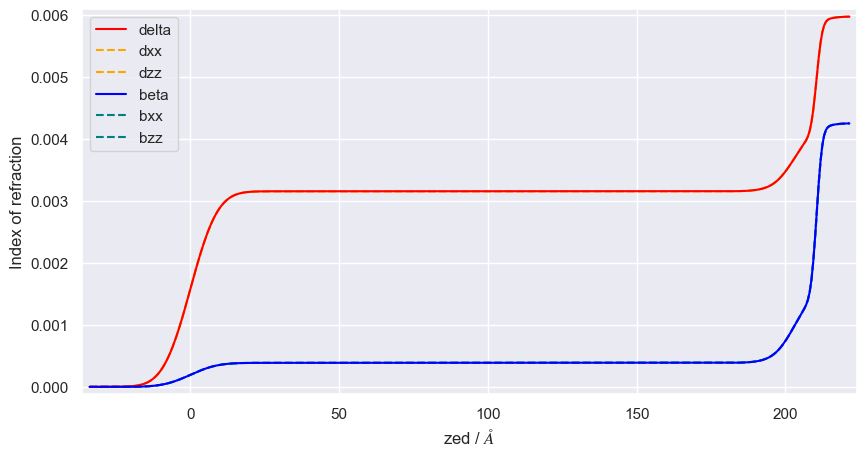

In [ ]:
""" 
Parameter Constraints
"""

max_thick = 300
max_rough = 10

sio2_t = 8.000003
sio2_rough = 6.38308
sio2_rho = 1.62331

carbon_thick = 6.08467
carbon_rough = 4.40733

znpc_thick = 196.441
znpc_rough = 7.21628

vac = PXR_MaterialSLD("", 1)(0, 0)
si = PXR_MaterialSLD("Si", 2.33, energy=en, name="Si")(0, 1.5)
sio2 = PXR_MaterialSLD("SiO2", sio2_rho, name="SiO2")(sio2_t, sio2_rough)
carbon = PXR_MaterialSLD("C", 1.8, name="Carbon")(carbon_thick, carbon_rough)

znpc = np.zeros(2, dtype=object)
znpc = PXR_MaterialSLD("C32H16N8Zn", 1.6, energy=en, name="ZnPc")(
    znpc_thick, znpc_rough
)
# znpc[1] = PXR_SLD()

struct = vac | znpc | carbon | sio2 | si
struct.plot()

structure = struct

(<Figure size 1000x500 with 1 Axes>, <Axes: >)

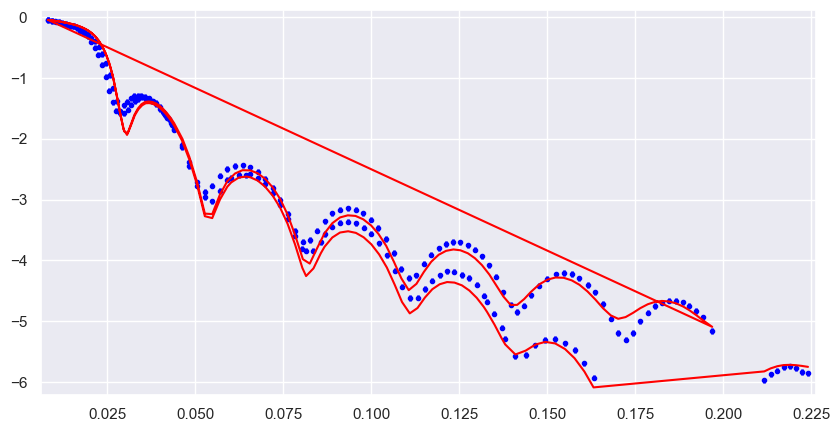

In [ ]:
from Logp import LogpExtra_rough

scale_vary = False
scale_lb = 0.6
scale_ub = 1.2

bkg_vary = False
bkg_lb = 1e-9
bkg_ub = 9e-6

random_state = 1
nwalkers = 200
nsamples = 200

move = [(DEMove(sigma=1e-7), 0.95), (DEMove(sigma=1e-7), 0.05)]
chain_name = "znpc_room_temp.txt"
save_fitter = "znpc_room_temp_fitter.pkl"

model = PXR_ReflectModel(
    structure, scale=1, bkg=0, dq=0, energy=en, pol="sp", name=f"ZnPc_{en}"
)

model.scale.setp(vary=scale_vary, bounds=(scale_lb, scale_ub))
model.bkg.setp(vary=bkg_vary, bounds=(bkg_lb, bkg_ub))

objective = Objective(model, znpc_data, transform=Transform("logY"), name=f"obj_{en}")
lpe = LogpExtra_rough(objective)
objective.logp_extra = lpe
objective.plot()

In [ ]:
sio2.thick.setp(vary=False)
sio2.rough.setp(vary=False)

carbon.thick.setp(vary=False)
carbon.rough.setp(vary=False)
carbon.sld.density.setp(vary=True, bounds=(0.7, 2))

znpc.thick.setp(vary=True, bounds=(max_thick / 2, max_thick))
znpc.rough.setp(vary=True, bounds=(0, max_rough))
znpc.sld.density.setp(vary=True, bounds=(1.61, 1.62))

100%|██████████| 200/200 [00:47<00:00,  4.19it/s]


________________________________________________________________________________
Parameters:      None      
<Parameter: 'ZnPc_thick'  , value=197.023 +/- 1.77 , bounds=[150.0, 300.0]>
<Parameter:     'rho'     , value=1.61155 +/- 0.00298, bounds=[1.61, 1.62]>
<Parameter: 'ZnPc_rough'  , value=8.30832 +/- 0.715, bounds=[0.0, 10.0]>
<Parameter:     'rho'     , value=1.73352 +/- 0.328, bounds=[0.7, 2.0]>


(<Figure size 1000x500 with 1 Axes>,
 <Axes: xlabel='zed / $\\AA$', ylabel='Index of refraction'>)

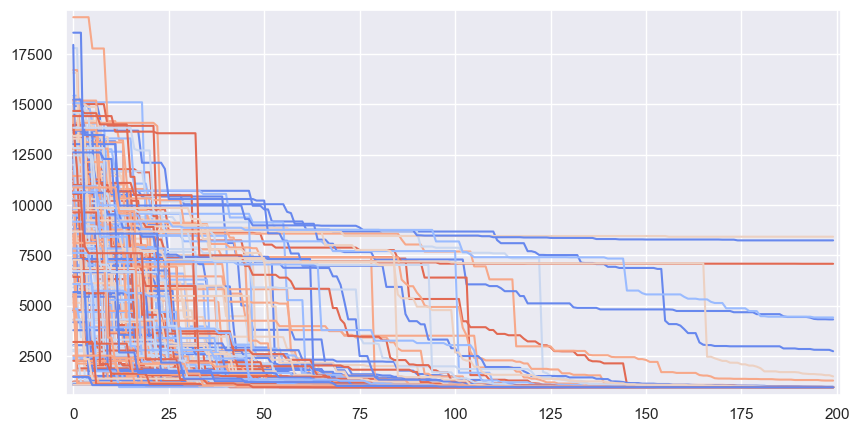

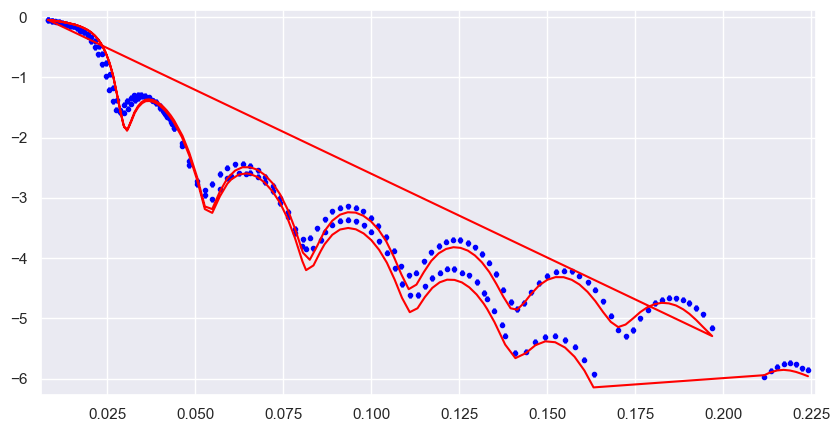

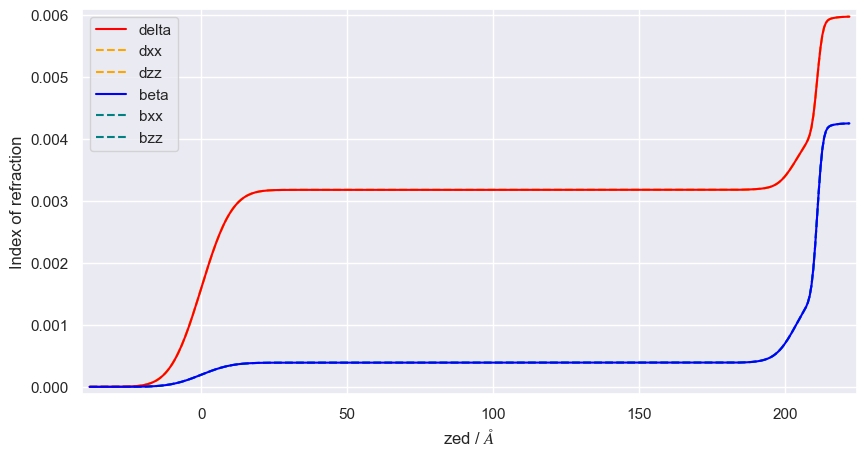

In [ ]:
fitter = CurveFitter(objective, nwalkers=nwalkers, moves=move)
fitter.initialise("prior")
chain = fitter.sample(int(nsamples), random_state=random_state)
lp = fitter.logpost
plt.plot(-lp)

print(objective.varying_parameters())
objective.plot()
structure.plot()

100%|██████████| 400/400 [01:49<00:00,  3.65it/s]


________________________________________________________________________________
Parameters:      None      
<Parameter: 'ZnPc_thick'  , value=197.028 +/- 0.139, bounds=[150.0, 300.0]>
<Parameter:     'rho'     , value=1.61011 +/- 0.000128, bounds=[1.61, 1.62]>
<Parameter: 'ZnPc_rough'  , value=8.26891 +/- 0.121, bounds=[0.0, 10.0]>
<Parameter:     'rho'     , value=1.85479 +/- 0.0751, bounds=[0.7, 2.0]>


(<Figure size 1000x500 with 1 Axes>,
 <Axes: xlabel='zed / $\\AA$', ylabel='Index of refraction'>)

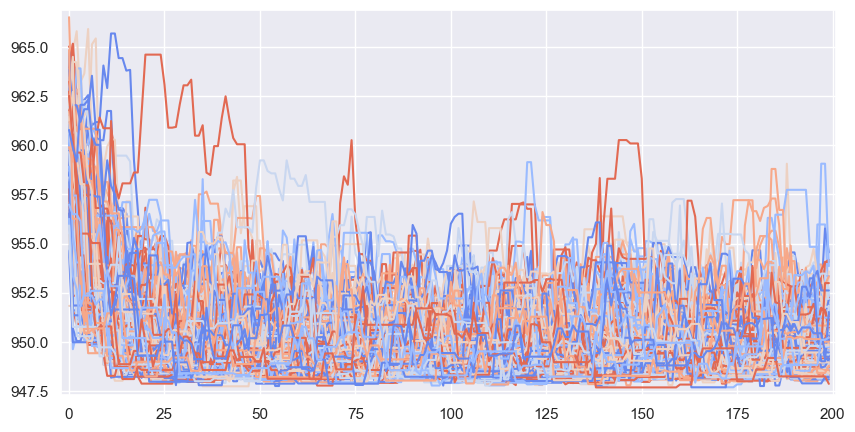

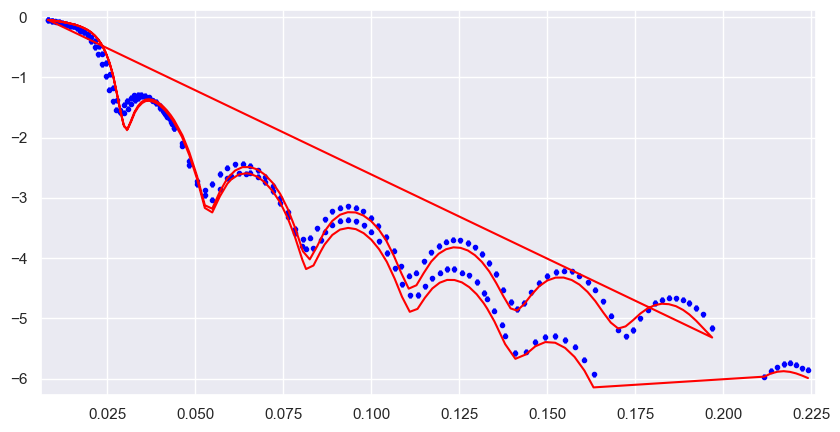

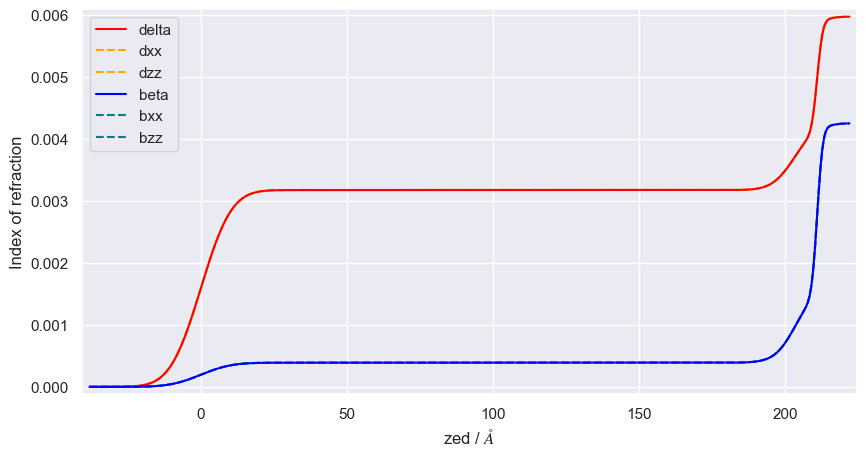

In [ ]:
fitter = CurveFitter(objective, nwalkers=nwalkers, moves=move)
fitter.initialise("jitter")
chain = fitter.sample(int(nsamples), nthin=2, random_state=random_state)
lp = fitter.logpost
plt.plot(-lp)

print(objective.varying_parameters())
objective.plot()
structure.plot()

In [ ]:
with open(d_path / save_fitter, "wb") as f:
    pickle.dump(fitter, f)

with open(d_path / chain_name, "wb") as f:
    f.write(str(objective.parameters).encode())

# C60 Bilayer

(<Figure size 1000x500 with 1 Axes>,
 <Axes: xlabel='zed / $\\AA$', ylabel='Index of refraction'>)

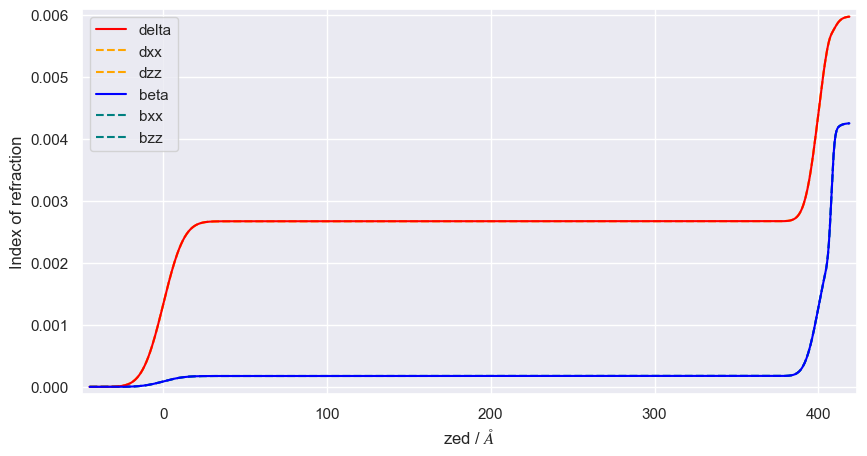

In [ ]:
en = 250

sio2_t = 8.000003
sio2_rough = 6.38308
sio2_rho = 1.62331

carbon_thick = 6.08467
carbon_rough = 4.40733

# znpc_thick = 196.441
# znpc_rough = 7.21628

# c60_thick = znpc_thick/2
# c60_rough = znpc_rough*2

bulk_t = 400
bulk_r = 10

vac = PXR_MaterialSLD("", 1)(0, 0)
si = PXR_MaterialSLD("Si", 2.33, energy=en, name="Si")(0, 1.5)
sio2_1 = PXR_MaterialSLD("SiO2", 2.33, energy=en, name="Si")(sio2_t, sio2_rough)
# c60_1 = PXR_MaterialSLD("C60", 1.6, energy=en, name="C60")(c60_thick, c60_rough)
# znpc_1 = PXR_MaterialSLD("C32H16N8Zn", 1.6, energy=en, name="ZnPc")(znpc_thick, znpc_rough)
bulk = PXR_MaterialSLD("C", 1.6, energy=en, name="Bulk")(bulk_t, bulk_r)

struct_1 = vac | bulk | sio2_1 | si

struct_1.plot()

(<Figure size 1000x500 with 1 Axes>, <Axes: >)

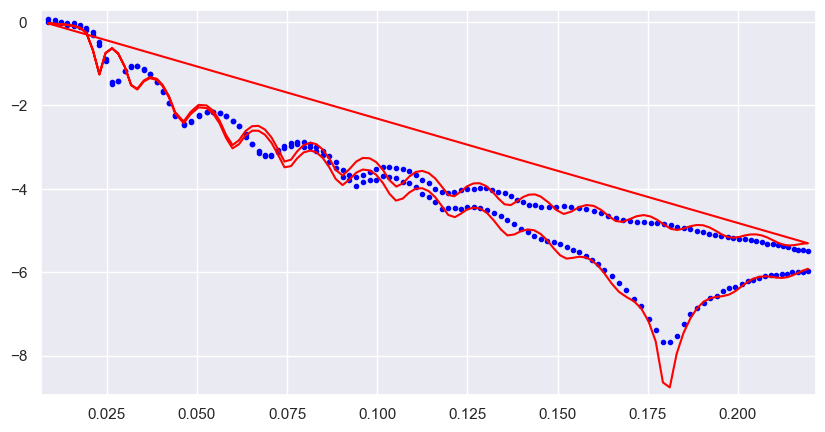

In [ ]:
from Logp import LogpExtra_rough

scale_vary = False
scale_lb = 0.6
scale_ub = 1.2

bkg_vary = False
bkg_lb = 1e-9
bkg_ub = 9e-6

random_state = 1
nwalkers = 200
nsamples = 200

move = [(DEMove(sigma=1e-7), 0.95), (DEMove(sigma=1e-7), 0.05)]
chain_name = "bilayer.txt"
save_fitter = "bilayer.pkl"

model = PXR_ReflectModel(
    struct_1, scale=1, bkg=0, dq=0, energy=en, pol="sp", name=f"bilayer{en}"
)

model.scale.setp(vary=scale_vary, bounds=(scale_lb, scale_ub))
model.bkg.setp(vary=bkg_vary, bounds=(bkg_lb, bkg_ub))

objective_1 = Objective(model, c60_data, transform=Transform("logY"), name=f"obj_{en}")
lpe = LogpExtra_rough(objective_1)
objective_1.logp_extra = lpe
objective_1.plot()

In [ ]:
max_thick = 450
max_rough = 100

sio2_1.thick.setp(vary=False)
sio2_1.rough.setp(vary=False)

carbon.thick.setp(vary=False)
carbon.rough.setp(vary=False)
carbon.sld.density.setp(vary=False, bounds=(1.5, 2))

bulk.thick.setp(vary=True, bounds=(max_thick / 2, max_thick))
bulk.rough.setp(vary=True, bounds=(0, max_rough))
bulk.sld.density.setp(vary=True, bounds=(1.5, 3))

100%|██████████| 200/200 [00:41<00:00,  4.76it/s]


________________________________________________________________________________
Parameters:      None      
<Parameter: 'Bulk_thick'  , value=246.99 +/- 9.06 , bounds=[225.0, 450.0]>
<Parameter:     'rho'     , value=1.61189 +/- 0.0839, bounds=[1.5, 3.0]>
<Parameter: 'Bulk_rough'  , value=12.5705 +/- 17.4 , bounds=[0.0, 100.0]>


(<Figure size 1000x500 with 1 Axes>,
 <Axes: xlabel='zed / $\\AA$', ylabel='Index of refraction'>)

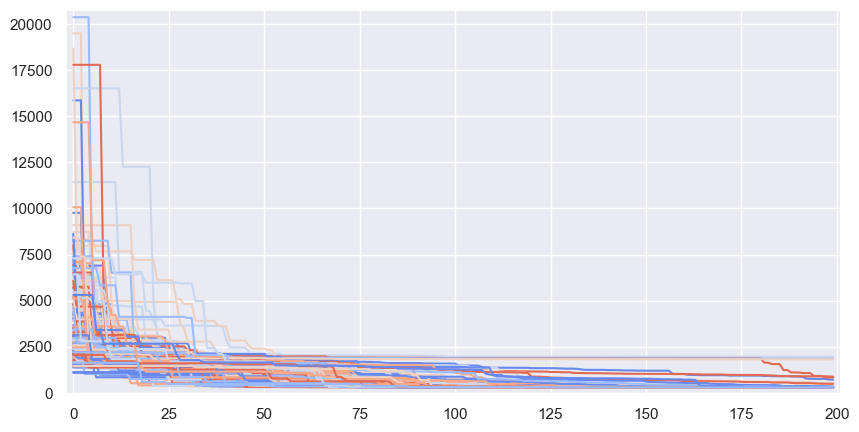

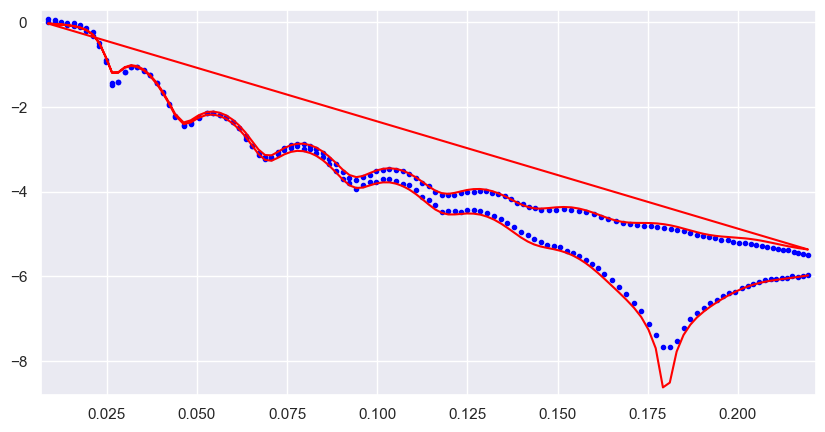

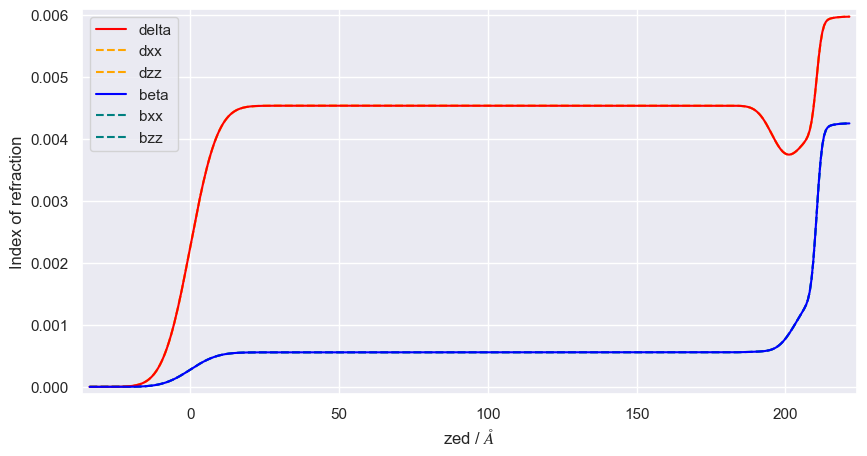

In [ ]:
fitter_2 = CurveFitter(objective_1, nwalkers=nwalkers, moves=move)
fitter_2.initialise("prior")
chain = fitter_2.sample(int(nsamples), random_state=random_state)
lp = fitter_2.logpost
plt.plot(-lp)

print(objective_1.varying_parameters())
objective_1.plot()
struct.plot()

100%|██████████| 2000/2000 [09:44<00:00,  3.42it/s]


________________________________________________________________________________
Parameters:      None      
<Parameter: 'Bulk_thick'  , value=246.789 +/- 0.275, bounds=[225.0, 450.0]>
<Parameter:     'rho'     , value=1.60449 +/- 0.0116, bounds=[1.5, 3.0]>
<Parameter: 'Bulk_rough'  , value=11.9395 +/- 0.209, bounds=[0.0, 100.0]>


(<Figure size 1000x500 with 1 Axes>,
 <Axes: xlabel='zed / $\\AA$', ylabel='Index of refraction'>)

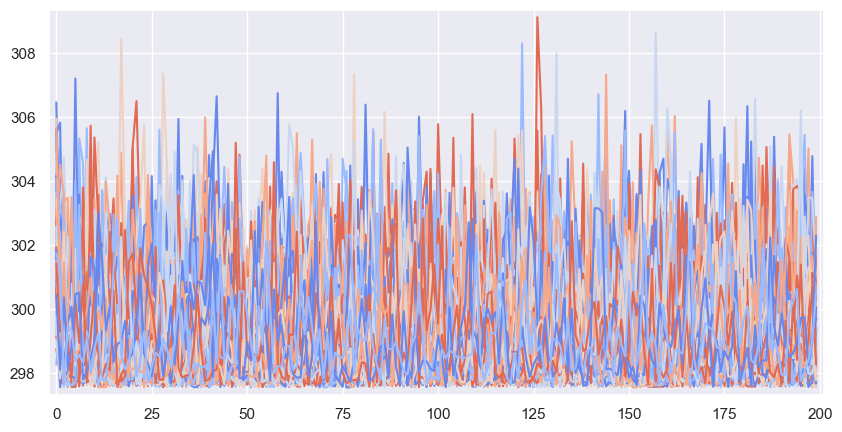

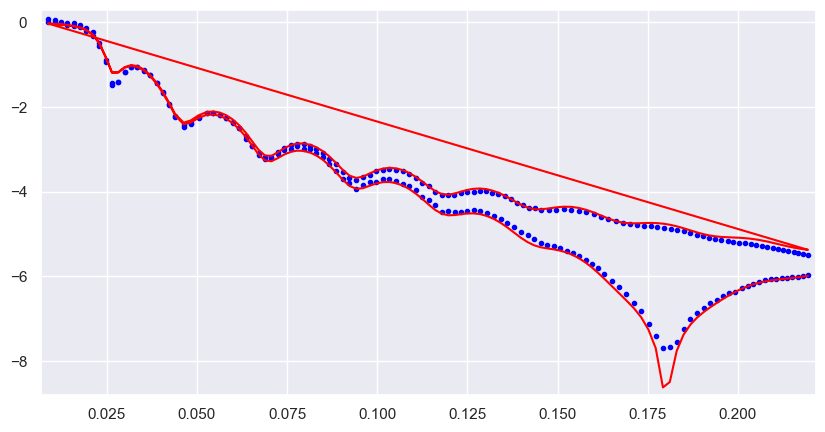

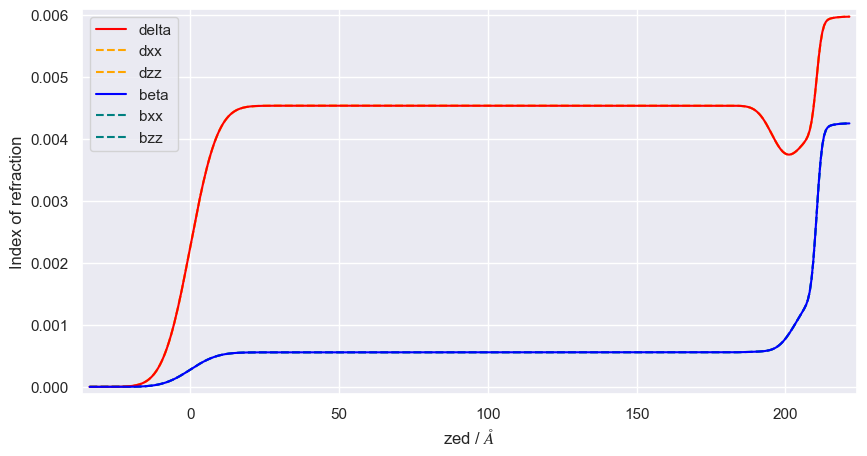

In [ ]:
fitter_2 = CurveFitter(objective_1, nwalkers=nwalkers, moves=move)
fitter_2.initialise("jitter")
chain = fitter_2.sample(int(nsamples), nthin=10, random_state=random_state)
lp = fitter_2.logpost
plt.plot(-lp)

print(objective_1.varying_parameters())
objective_1.plot()
struct.plot()

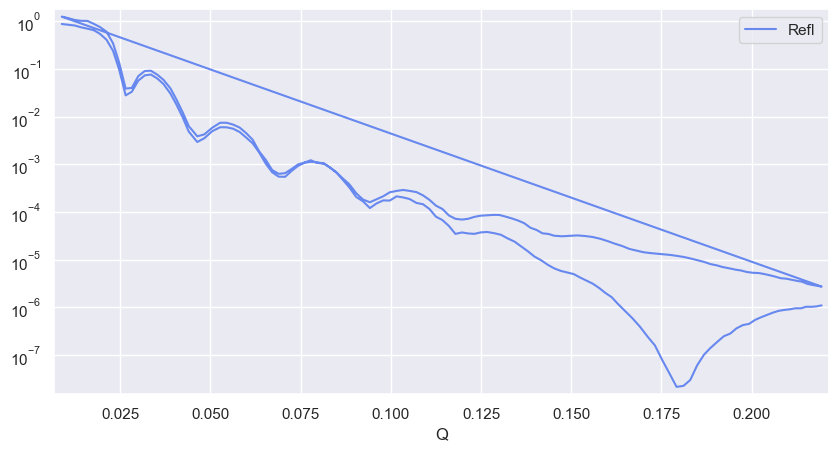

In [ ]:
c60_283p7 = pd.concat(
    [
        pd.read_csv(
            d_path / "C60-ZnPc_250.0_100.0_refl (CCD Scan 82877).csv", index_col=0
        ),
        pd.read_csv(
            d_path / "C60-ZnPc_250.0_190.0_refl (CCD Scan 82876).csv", index_col=0
        ),
    ]
)

c60_283p7 = c60_283p7[c60_283p7.Q > 0.008]
c60_283p7.plot(x="Q", y="Refl", logy=True)

c60_283p7_data = to_refnx_dataset(c60_283p7)

# Multi Energy Fitting

(<Figure size 1000x500 with 1 Axes>,
 <Axes: xlabel='zed / $\\AA$', ylabel='Index of refraction'>)

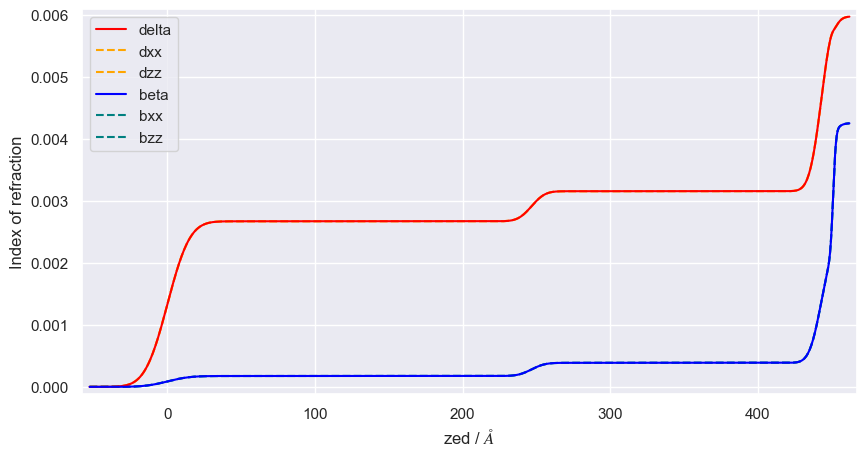

In [ ]:
from turtle import st


max_thick = bulk.thick.value
max_rough = bulk.rough.value

znpc_thick = 196.441
znpc_rough = 7.21628

c60_thick = max_thick - znpc_thick
c60_rough = max_rough * 2

c60_1 = PXR_MaterialSLD("C60", 1.6, energy=en, name="C60")(max_thick, max_rough)
znpc_1 = PXR_MaterialSLD("C32H16N8Zn", 1.6, energy=en, name="ZnPc")(
    znpc_thick, znpc_rough
)

struct_1 = vac | c60_1 | znpc_1 | sio2_1 | si
struct_1.plot()

Error plotting BareSi 250.0 100
Error plotting C60-ZnPc 250.0 100
Error plotting C60-ZnPc 250.0 100
Error plotting C60-ZnPc 250.0 100
Error plotting C60-ZnPc 250.0 100
Error plotting C60-ZnPc 283.7 100
Error plotting C60-ZnPc 284.0 100


KeyboardInterrupt: 

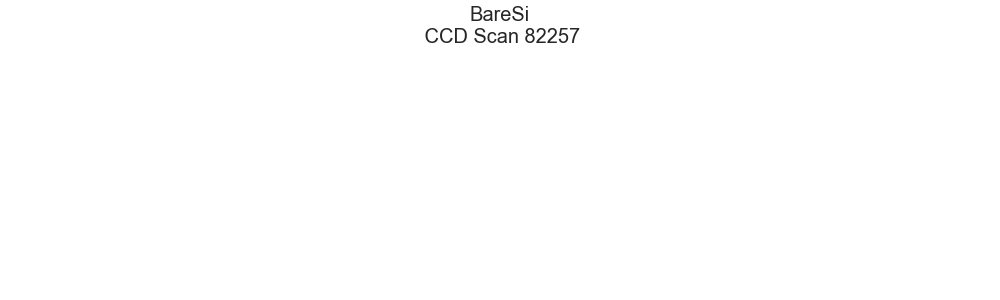

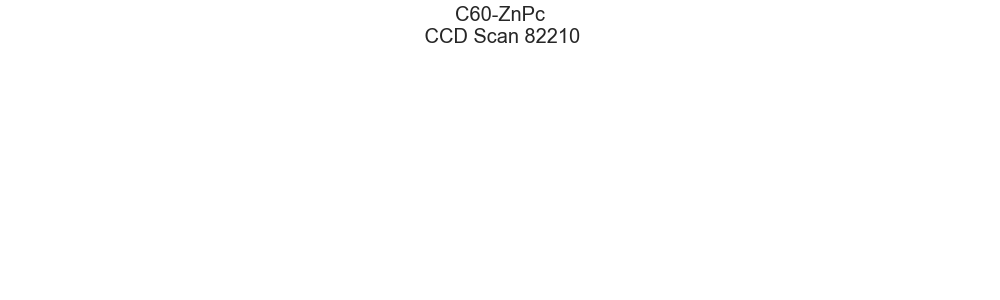

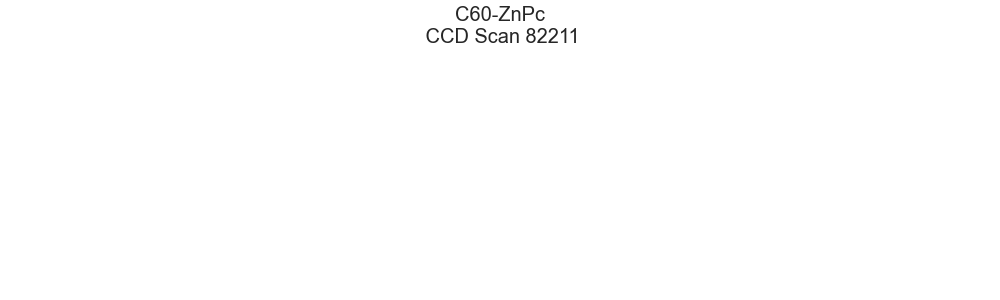

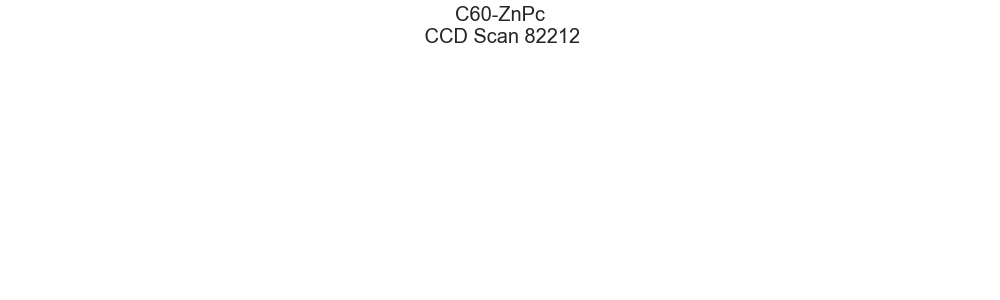

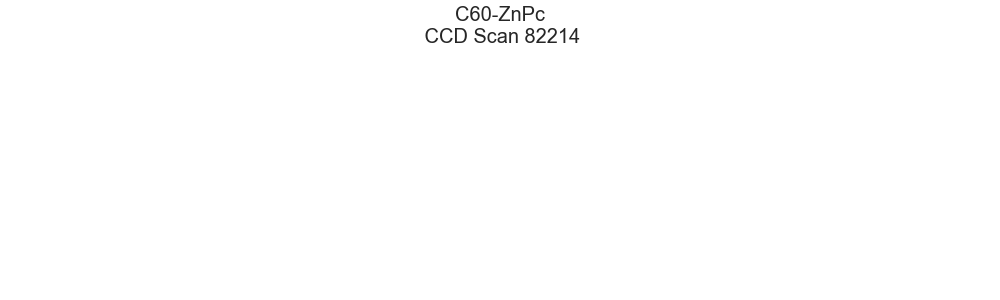

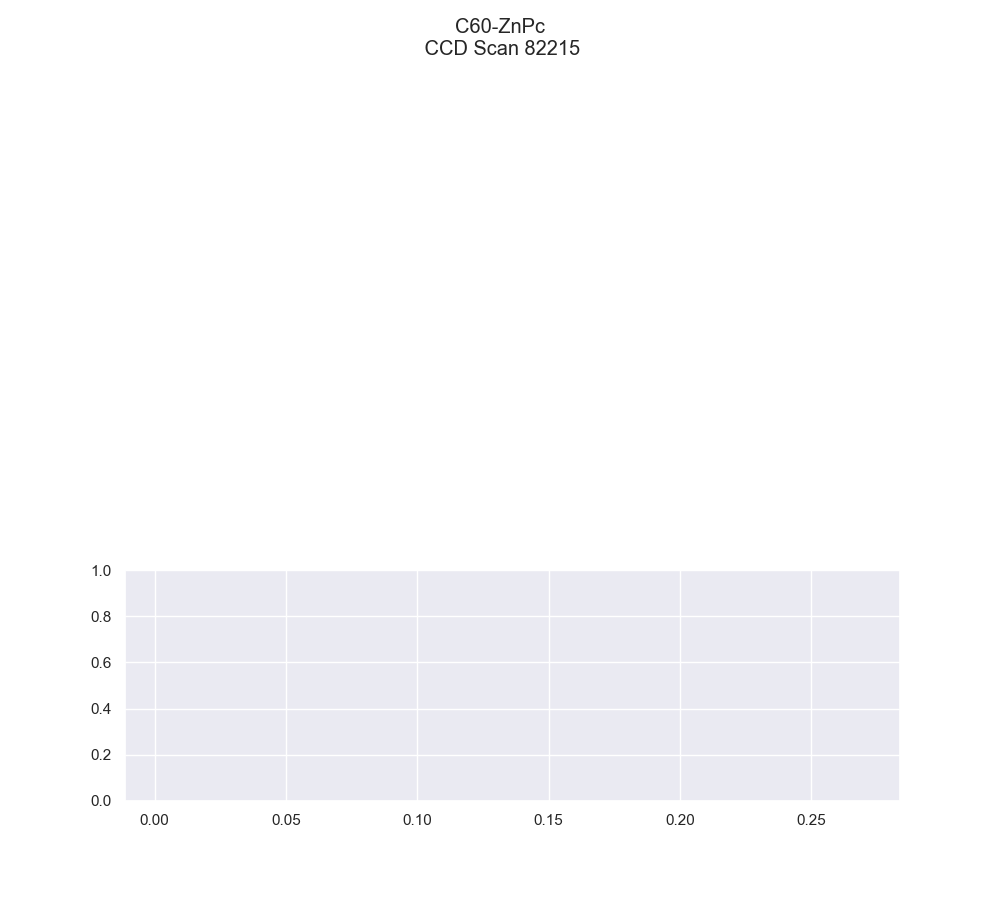

In [ ]:
# def plot_sample(sample_path):
#     for scan in sample_path.iterdir():
#         if not scan.is_dir():
#             continue
#         energies = [en for en in scan.iterdir() if en.is_dir()]
#         fig, ax = plt.subplots(
#             nrows=len(energies),
#             figsize=(10, 3 * len(energies)),
#             sharex=True,
#             gridspec_kw={"wspace": 0, "hspace": 0},
#         )
#         fig.suptitle(f"{sample_path.stem}\n {scan.stem}")
#         for i, en in enumerate(energies):
#             if not en.is_dir():
#                 continue
#             for pol in en.iterdir():
#                 if not pol.is_dir():
#                     continue
#                 if isinstance(ax, np.ndarray):
#                     axes = ax[i]
#                 else:
#                     axes = ax
#                 try:
#                     xrr = ru.Refl(path=pol)
#                     xrr.plot(ax=axes, label=f"{en.name} {pol.stem}")
#                     xrr.to_parquet()
#                     xrr.to_csv()
#                 except Exception as e:
#                     print(f"Error plotting {sample_path.stem} {en.name} {pol.stem}")
#                     axes.remove()


# import warnings

# warnings.filterwarnings("ignore")


# # FILEPATH: /c:/Users/Harlan Heilman/CarbonLab/Refl-Utils/src/RoomTempFitting.ipynb
# def plot_bt():
#     processed_path = ru.FileDialog.getDirectory(title="Select Processed Directory")
#     samples = [s for s in processed_path.iterdir() if s.is_dir()]
#     for sample in samples:
#         plot_sample(sample)


# plot_bt()